<a href="https://colab.research.google.com/github/preqon/neurosparks-gtec-hack/blob/main/AI_in_Neural_Engineering_Workshop_Demo_Code_Sep2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Build Binary Classifier (PD vs. HC) Given Task EEG - Simon Conflict Task

This notebook covers a Python-based machine learning code to build a binary classifer that distinguish PD patients from Healthy controls (HC). **It follows the workshop slides and is not intended to stand on its own.** It runs only with partiall code and data from the actul paper, so does not intend to replicate the result of the paper with the following code.

Full credit to the paper, please cite our work if used:

Sun, X., Zhao, C., Koorathota, S., & Sajda, P. (2024). EEG-estimated functional connectivity, and not behavior, differentiates Parkinson's patients from health controls during the Simon conflict task. In 2024 46th Annual International Conference of the IEEE Engineering in Medicine & Biology Society (EMBC)


This includes following modules:


1.   Initial setups
    *   Library loading
    *   Define functions
        * Long Short-Term Memory (LSTM)
        * Convolutional Neural Network (CNN)
2.   Data loading - Example Data [Download](https://www.dropbox.com/scl/fo/hiy8y06koiuf7cwdj747j/ADQeXOnCTIYVmyo9SZWzfwg?rlkey=rtedugtdq4med4oyjeis3qp3m&st=310988de&dl=0)
    * Mount Drive
    * Parameters setting
3.   Prepare model inputs
    * Merge dataset
    * Shape the input layer
    * Traing & Testing split
4.   Start Training
    * N-fold cross validation
    * Updating best validation model
    * Testing set accuracy
5.   Result Summary
    * Model parameters summary
    * Plot model training result

## Initial setups

Let's start by importing some libraries.

In [ ]:
import numpy as np
import os
from matplotlib import pyplot as plt
from glob import glob
import natsort
from scipy.io import loadmat
from sklearn.model_selection import train_test_split


from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

import re

import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv2D, MaxPooling2D, Flatten, Dense,AveragePooling2D,Dropout,BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from keras.models import clone_model

Here, we will define the needed functions. We will use two different machine learning models in this demo and we will define them here:
  

* Long Short-Term Memory (LSTM)
* Convolutional Neural Network (CNN)   

   



LSTM is a type of recurrent neural network (RNN) architecture designed to effectively model sequential data, such as time series or natural language. Unlike traditional RNNs, LSTMs are capable of learning long-term dependencies by utilizing a memory cell that can maintain information across time steps. This memory cell, along with three key gates—input, output, and forget gates—controls the flow of information, allowing the network to retain, update, or discard information as needed. LSTMs are widely used in tasks like language modeling, speech recognition, and time series forecasting, where understanding context over long sequences is crucial.

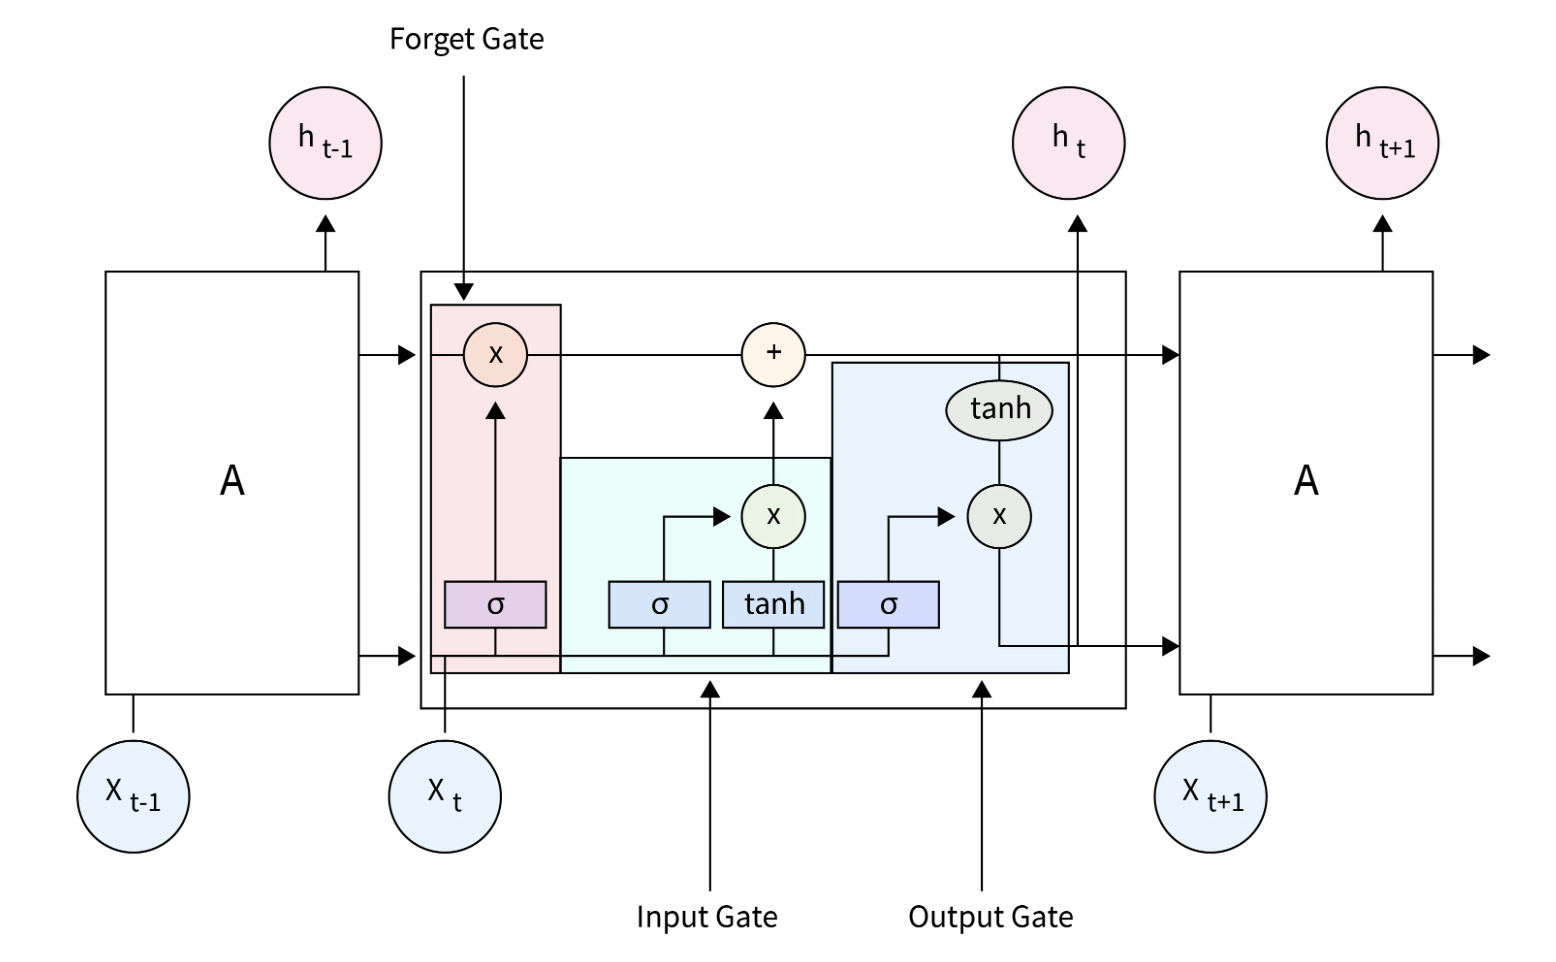
[Image Source](https://www.scaler.com/topics/deep-learning/lstm/)

In [ ]:
# Define a function to build the LSTM model
lstm_para = 8
lstm_para2 = 8
full_para = 64


def model_built_LSTM(timesteps, features, num_classes, lstm_para, lstm_para2, full_para):
    # LSTM layer
    model = Sequential()
    model.add(LSTM(units=lstm_para, input_shape=(timesteps, features), return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))  # Add dropout for regularization
    model.add(LSTM(units=lstm_para2, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))

    # Dense layer
    model.add(Dense(units=full_para, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(units=num_classes, activation='sigmoid'))
    return model

A Convolutional Neural Network (CNN) is a specialized type of deep learning model primarily used for processing and analyzing visual data, such as images and videos. CNNs are designed to automatically and adaptively learn spatial hierarchies of features through the use of convolutional layers, which apply filters to input data to detect patterns like edges, textures, and more complex structures. These layers are followed by pooling layers that reduce the spatial dimensions, helping the network focus on the most important features while reducing computational complexity. CNNs are widely used in image classification, object detection, and other computer vision tasks due to their ability to capture and interpret visual patterns effectively.

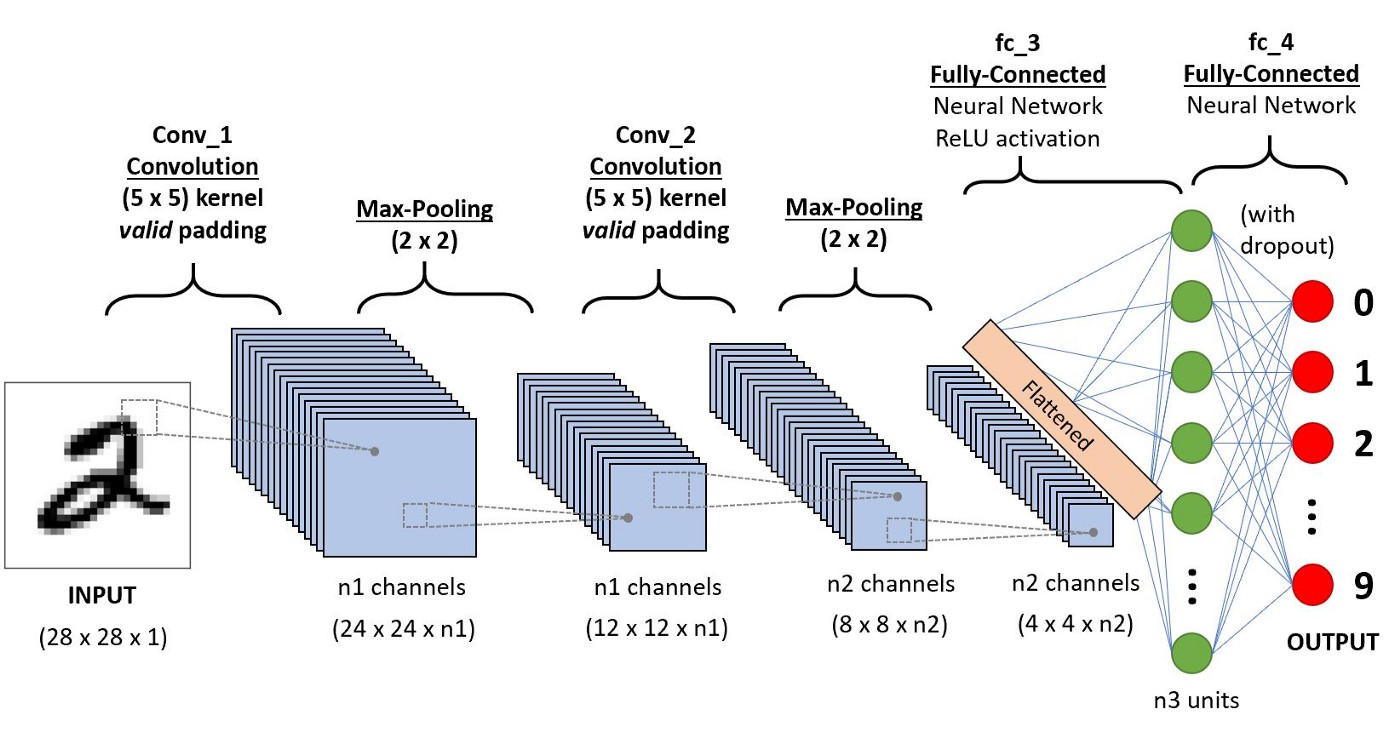
[Image Source](https://paperswithcode.com/methods/category/convolutional-neural-networks)

In [ ]:
# Define a function to build the CNN model
cnn_para = 16
full_para = 32

def model_built_CNN(input_shape, num_classes,cnn_para,full_para):
    model = Sequential()
    # Convolutional Layer 1
    model.add(Conv2D(cnn_para, kernel_size=(5, 5), input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(Activation('relu'))  # Add ReLU activation
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten
    model.add(Flatten())

    # Fully Connected Layer 1
    model.add(Dense(full_para,kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(Activation('relu'))  # Add tanh activation


    # Output Layer
    model.add(Dense(num_classes, activation='sigmoid'))

    return model

In [ ]:
## Define necessary functions

# function to create training labels
def create_labels(eeg1,eeg2):
    # Create labels based on given dataset
    y = np.hstack((np.zeros(eeg1.shape[2]),np.ones(eeg2.shape[2])))
    label = y.reshape(y.shape[0],1)
    return np.array(label,dtype = int)

## Review of the experiment and input features

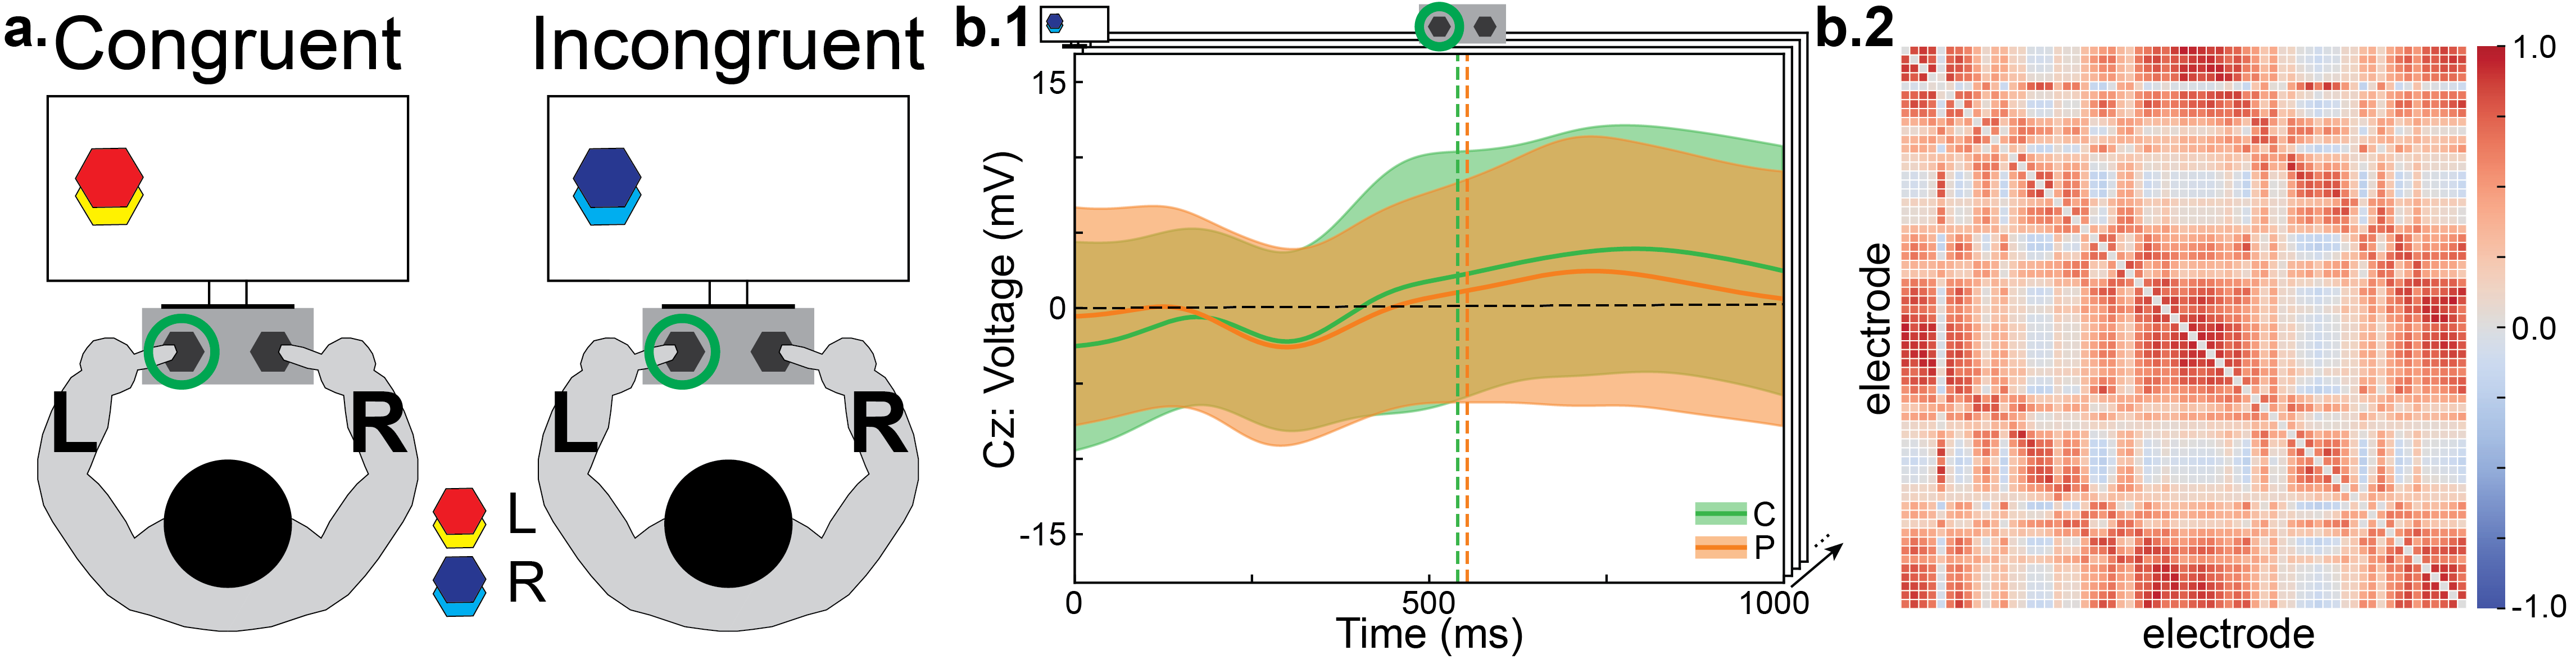

LSMT - Temporal Feature (63 × 500): 1-second after stimulus onset, sample rate is 500 Hz.\
CNN - Spatial Feature (63 × 63): 1-second after stimulus onset, symmetric matrix calculated based on the 1-second time series (Pearson Correlation).

## Load data - temporal features

sync to your drive to load the pre-processed dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Define some global and constant variables/parameters before the loading and training.

In [ ]:
# Dataset related parameters
class_cond = 2 # 1 for congruent trials, 2 for incongruent trials
band = 'theta' # use the theta band (4-7 Hz) data or delta band (1-4 Hz)
index = 'amp' # use the amplitude data, which is the temporal features

# We provided two types of datasets as examples for this workshop
#1. congruent trials with delta band
#class_cond = 1
#band = 'delta'

#1. incongruent trials with theta band
#class_cond = 2
#band = 'theta'

# EEG data related parameters
srate = 500 # sampling rate - 500 Hz
timesteps = 1*srate # 1 second after stimulus onset
channels = 63 # number of used channels
features = channels # number of features is the same as number of used channels

# Model related parameters
num_folds = 5 #10
num_classes = 1  # Number of output classes, binary classifier
num_epochs = 20
batch_size = 32
custom_learning_rate = 1e-3 # Learning rate
patience_num = 5 # For early stopping

In [ ]:
loaded_data = np.load('/content/drive/My Drive/'+ index + '_use_' + band + '_merge_control_patient_' + str(class_cond) + '_trim.npz')
c1_index_all = loaded_data['c1_index_all'] # trials from healthy control
c2_index_all = loaded_data['c2_index_all'] # trials from PD patients
## Print loading result
print(index+'_use_'+ band +'_merge_control_patient_'+ str(class_cond))
print('Number of trials from HC:' + str(c1_index_all.shape[2]))
print('Number of trials from PD:' + str(c2_index_all.shape[2]))

amp_use_theta_merge_control_patient_2
Number of trials from HC:500
Number of trials from PD:500


## Prepare model input

In [ ]:
# merging dataset
X_EEG = np.concatenate([c1_index_all, c2_index_all], axis=2)
X_EEG = X_EEG.transpose([2,1,0])
y = create_labels(c1_index_all,c2_index_all)

#class weights for imbalanced classes
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(np.ravel(y,order='C')),y = np.ravel(y,order='C'))
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

print(X_EEG.shape)

(1000, 500, 63)


In [ ]:
# Train & Test split
X_train, X_test, y_train, y_test = train_test_split(X_EEG, y, test_size=0.2, random_state=42)

X_EEG = X_train
y = y_train

## Let's train the model!

In [ ]:
## Cross Validating
# N-fold cross validation
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)


best_model = None
best_val_loss = float('inf')

validation_acc = []
train_acc = []


for i, (train, val) in enumerate(kfold.split(X_EEG, y)):
    print('Cross Validating')
    print(f'\nFold {i+1}')
    # Build the model with pre-defined LSTM model
    model = model_built_LSTM(timesteps, features, num_classes, lstm_para, lstm_para2, full_para)

    # Define optimizer
    custom_optimizer = Adam(learning_rate=custom_learning_rate)

    # Compile model
    es = EarlyStopping(monitor='val_loss', patience=patience_num , verbose=0)
    model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

    # Train the model
    history = model.fit(X_EEG[train], y[train],
                            validation_data=(X_EEG[val], y[val]),
                            shuffle=True, epochs=num_epochs,
                            batch_size=batch_size,
                            class_weight=class_weights_dict,
                            callbacks=[es], verbose=0)

    # Get the validation loss from the history object
    temp_val_loss = history.history['val_loss'][-1]
    temp_val_acc = history.history['val_accuracy'][-1]
    validation_acc.append(history.history['val_accuracy'][-1])

    temp_train_acc = history.history['accuracy'][-1]
    train_acc.append(temp_train_acc)


    print(f'The accuracy on train data = {temp_train_acc*100:.3}%')
    print(f'The accuracy on validation data = {temp_val_acc*100:.3}%')

    # Update the best model
    if temp_val_loss < best_val_loss:
        best_model = clone_model(model)
        best_model.set_weights(model.get_weights())  # Copy weights
        best_val_loss = temp_val_loss
        best_model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])
        print(f'The accuracy of the LSTM model on test data = {best_model.evaluate(X_test, y_test)[1]*100:.3}%')


print('Done')


Cross Validating

Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The accuracy on train data = 94.1%
The accuracy on validation data = 87.5%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8796 - loss: 0.6798
The accuracy of the LSTM model on test data = 88.5%
Cross Validating

Fold 2
The accuracy on train data = 89.8%
The accuracy on validation data = 78.1%
Cross Validating

Fold 3
The accuracy on train data = 90.3%
The accuracy on validation data = 81.9%
Cross Validating

Fold 4
The accuracy on train data = 95.9%
The accuracy on validation data = 88.7%
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.8856 - loss: 0.6194
The accuracy of the LSTM model on test data = 90.0%
Cross Validating

Fold 5
The accuracy on train data = 91.4%
The accuracy on validation data = 86.3%
Done


In [ ]:
best_model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])
print(f'The accuracy on test data = {best_model.evaluate(X_test, y_test)[1]*100:.3}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8856 - loss: 0.6194
The accuracy on test data = 90.0%


## Result visualization

Model Structure: Model Parameter Summary

In [ ]:
best_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 500, 8)              │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 500, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,765 (38.15 KB)

 Trainable params: 3,233 (12.63 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 6,468 (25.27 KB)

Plot training and validation accuracy result across folds.

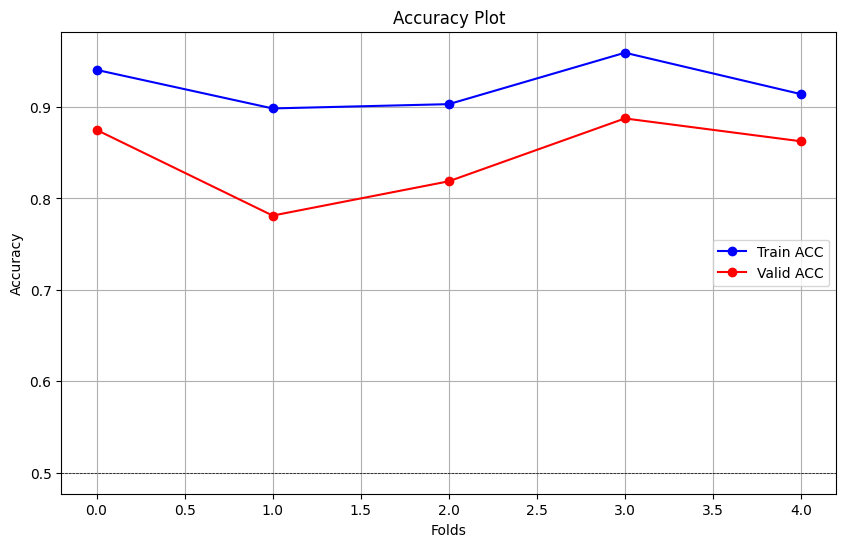

In [ ]:
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(train_acc,  linestyle='-', marker='o', color='blue', label='Train ACC')  # Plot line
plt.plot(validation_acc,  linestyle='-', marker='o', color='red', label='Valid ACC', )  # Plot line
plt.title('Accuracy Plot')  # Title of the plot
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.axhline(0.5, color='black', lw=0.5, ls='--')  # Add a horizontal line at y=0.5
plt.grid()  # Show grid
plt.legend()  # Show legend
plt.show()

## Load data - spatial features

Define some global and constant variables/parameters before the loading and training.

In [ ]:
# Dataset related parameters
class_cond = 1 # 1 for congruent trials, 2 for incongruent trials
band = 'delta' # use the theta band (4-7 Hz) data or delta band (1-4 Hz)
index = 'corr' # use the pearson correlation data, which is the spatial features

# We provided two types of datasets as examples for this workshop
#1. congruent trials with delta band
#class_cond = 1
#band = 'delta'

#1. incongruent trials with theta band
#class_cond = 2
#band = 'theta'


# EEG data related parameters
srate = 500 # sampling rate - 500 Hz
timesteps = 1*srate # 1 second after stimulus onset
channels = 63 # number of used channels
layers = 1 # input shape

# Model related parameters
num_folds = 5 #10
num_classes = 1  # Number of output classes, binary classifier
num_epochs = 20
batch_size = 32
custom_learning_rate = 1e-3 # Learning rate
patience_num = 5 # For early stopping

In [ ]:
loaded_data = np.load('/content/drive/My Drive/'+ index + '_use_' + band + '_merge_control_patient_' + str(class_cond) + '_trim.npz')
c1_index_all = loaded_data['c1_index_all'] # trials from healthy control
c2_index_all = loaded_data['c2_index_all'] # trials from PD patients
## Print loading result
print(index+'_use_'+ band +'_merge_control_patient_'+ str(class_cond))
print('Number of trials from HC:' + str(c1_index_all.shape[2]))
print('Number of trials from PD:' + str(c2_index_all.shape[2]))

corr_use_delta_merge_control_patient_1
Number of trials from HC:500
Number of trials from PD:500


## Prepare model input

In [ ]:
# merging dataset
X_index = np.concatenate([c1_index_all, c2_index_all], axis=2)
X_index = X_index.transpose([2,1,0])
y = create_labels(c1_index_all,c2_index_all)

#class weights for imbalanced classes
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(np.ravel(y,order='C')),y = np.ravel(y,order='C'))
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

# Define input shape for CNN
input_shape = (channels, channels, layers)
print(X_index.shape)

(1000, 63, 63)


In [ ]:
# Train & Test split
X_train, X_test, y_train, y_test = train_test_split(X_index, y, test_size=0.2, random_state=42)

X_index = X_train
y = y_train

## Let's train the model!

In [ ]:
## Cross Validating
# N-fold cross validation
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)

best_model = None
best_val_loss = float('inf')

validation_acc = []
train_acc = []

# Initialize variables to record training times
fold_training_times = []
best_epoch = []

for i, (train, val) in enumerate(kfold.split(X_index, y)):

    print('Cross Validating')
    print(f'\nFold {i+1}')
    # Build the model with
    model = model_built_CNN(input_shape, num_classes,cnn_para,full_para)
    custom_optimizer = Adam(learning_rate=custom_learning_rate)
    # Compile model
    es = EarlyStopping(monitor='val_loss', patience=patience_num, verbose=1)
    model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

    # Train the model
    history = model.fit(X_index[train], y[train],
                        validation_data=(X_index[val], y[val]),
                        shuffle=True, epochs=num_epochs,
                        batch_size=batch_size,
                        class_weight=class_weights_dict,
                        callbacks=[es], verbose=0) # remember to change verbose to 0

    # Get the validation loss from the history object
    temp_val_loss = history.history['val_loss'][-1]
    temp_val_acc = history.history['val_accuracy'][-1]
    validation_acc.append(history.history['val_accuracy'][-1])

    temp_train_acc = history.history['accuracy'][-1]
    train_acc.append(temp_train_acc)

    print(f'The accuracy on train data = {temp_train_acc*100:.3}%')
    print(f'The accuracy on validation data = {temp_val_acc*100:.3}%')

    if temp_val_loss < best_val_loss:
        best_model = clone_model(model)
        best_model.set_weights(model.get_weights())  # Copy weights
        best_val_loss = temp_val_loss
        best_model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])
        print(f'The accuracy of the LSTM model on test data = {best_model.evaluate(X_test, y_test)[1]*100:.3}%')

print('Done')

Cross Validating

Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 6: early stopping
The accuracy on train data = 99.2%
The accuracy on validation data = 49.4%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5398 - loss: 1.8648
The accuracy of the LSTM model on test data = 52.0%
Cross Validating

Fold 2
Epoch 7: early stopping
The accuracy on train data = 98.9%
The accuracy on validation data = 49.4%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5398 - loss: 1.7868
The accuracy of the LSTM model on test data = 52.0%
Cross Validating

Fold 3
Epoch 6: early stopping
The accuracy on train data = 99.4%
The accuracy on validation data = 49.4%
Cross Validating

Fold 4
Epoch 6: early stopping
The accuracy on train data = 99.4%
The accuracy on validation data = 49.4%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5398 - loss: 1.7014
The accuracy of the LSTM model on test data = 52.0%
Cross Validating

Fold 5
Epoch 6: early stopping
The accuracy on train data = 99.2%
The accuracy on validation data = 50.0%
Done


In [ ]:
best_model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])
print(f'The accuracy on test data = {best_model.evaluate(X_test, y_test)[1]*100:.3}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5398 - loss: 1.7014
The accuracy on test data = 52.0%


## Result visualization

Model Structure: Model Parameter Summary

In [ ]:
best_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 59, 59, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 59, 59, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 59, 59, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 29, 29, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 13456)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │         430,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,293,605 (4.93 MB)

 Trainable params: 431,169 (1.64 MB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 862,340 (3.29 MB)

Plot training and validation accuracy result across folds.

In [ ]:
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(train_acc,  linestyle='-', marker='o', color='blue', label='Train ACC')  # Plot line
plt.plot(validation_acc,  linestyle='-', marker='o', color='red', label='Valid ACC', )  # Plot line
plt.title('Accuracy Plot')  # Title of the plot
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.axhline(0.5, color='black', lw=0.5, ls='--')  # Add a horizontal line at y=0.5
plt.grid()  # Show grid
plt.legend()  # Show legend
plt.show()